# GrabCut: Foreground Segmentation and Extraction

## Spis treści
* ### Przedstawienie algorytmu
* ### Program wykonujący segmentacje na pdostawie kamerki laptopa
* ### Przykłady działania programu

## Przedstawienie algorytmu

Zaczynamy od załadowanie niezbędnych bibliotek oraz od wczytania obrazu na którym będziemy wykonywać segmentacje.

Tworzone są tez dwie inne zmienne:
* mask - macierz o wymiarach takich samych jak wczytany obraz. W tej zmiennej będzie przechowywana maska segmentacji.
* rect - opisuje prostokąt wewnątrz którego jest obiekt który chcemy wysegmentować, elementy zmiennej to odpowiednio: współrzędne lewego górnego rogu prostokąta, jego szerokość, jego wysokość

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time

image = cv2.imread("./images/face_1.jpg")
mask = np.zeros(image.shape[:2], dtype="uint8")
rect = (203, 0, 230, 400)

Ponizej mozemy zobaczyć jak wygląda obraz źródłowy

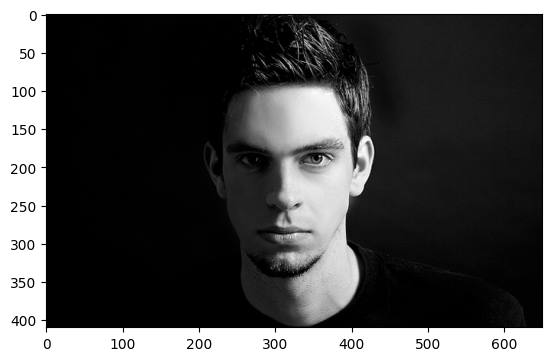

In [2]:
plt.imshow(image)

W kolejnej komórce dokonujemy segmentacji za pomocą algorytmu **GrabCut** zaimplementowanego w bibliotece opencv.

Aby z niego korzystać konieczne jest stworzenie dwóch tablic **bgModel** i **fgModel** które są wykorzystywane przez algorytm.

Algorytm **GrabCut** mozna zainicjować albo za pomocą prostokąta zaznaczającego gdzie znajduje się obiekt który segmentujemy albo za pomocą maski. W tym notatniku ograniczę się do metody z uzyciem prostokąta.

Dodatkowym parametrem jest **iterCount** liczba iteracji które algorytm wykona.
Za pomocą biblioteki **time** mierzony jest czas działania algorytmu.



In [3]:
fgModel = np.zeros((1, 65), dtype="float")
bgModel = np.zeros((1, 65), dtype="float")
# apply GrabCut using the the bounding box segmentation method
start = time.time()
cv2.grabCut(image, mask, rect, bgModel,
	fgModel, iterCount=10, mode=cv2.GC_INIT_WITH_RECT)
end = time.time()
print("[INFO] zaapliakowanie GrabCut zajęło {:.2f} sekund".format(end - start))

[INFO] zaapliakowanie GrabCut zajęło 1.51 sekund


Po zastosowaniu algorytmu wewnątrz zmiennej **mask** znajduję się 4 rodzaje wartośći:
* Definite Background - wartość tą mają piksele znajdujące się poza prostokątem 
* Probable Background - wartość tą mają piksele wewnątrz prostokąta które zostały zaklasyfikowane jako tło
* Definite Foreground - wartość tą mają piksele które na pewno przedstawiają segmentowany obiekt.
* Probable Foreground - wartość tą mają piksele które są wewnątrz prostokąta i zostały zaklasyfikowane jako segmentowany obiekt

Ponizszy kod wyświetlą w takiej samej jak wyej kolejności, kazdą z grup pikseli.

[INFO] showing mask for 'Definite Background'


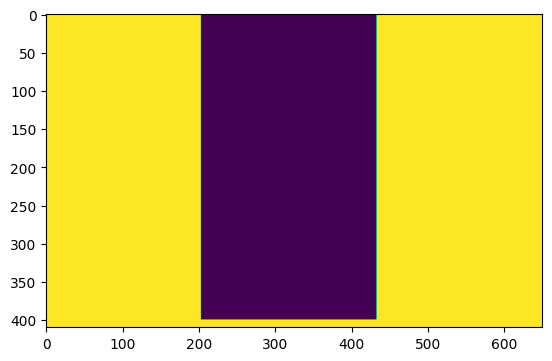

[INFO] showing mask for 'Probable Background'


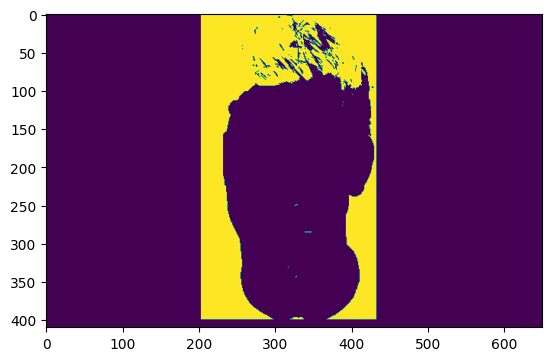

[INFO] showing mask for 'Definite Foreground'


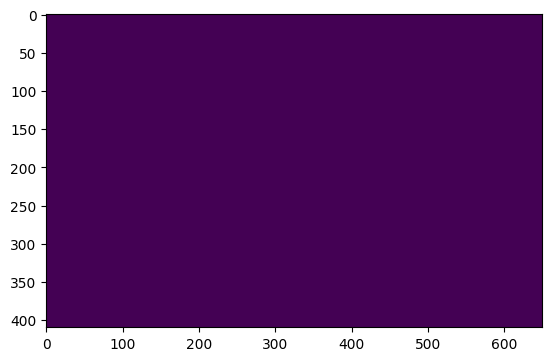

[INFO] showing mask for 'Probable Foreground'


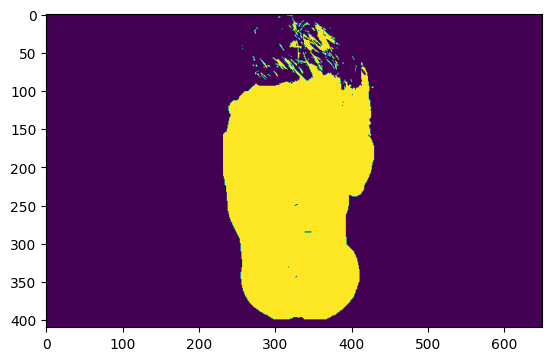

In [4]:
#%matplotlib inline
values = (
	("Definite Background", cv2.GC_BGD),
	("Probable Background", cv2.GC_PR_BGD),
	("Definite Foreground", cv2.GC_FGD),
	("Probable Foreground", cv2.GC_PR_FGD),
)
# loop over the possible GrabCut mask values
for (name, value) in values:
	# construct a mask that for the current value
	print("[INFO] showing mask for '{}'".format(name))
	valueMask = (mask == value).astype("uint8") * 255
	# display the mask so we can visualize it
	plt.imshow(valueMask)
	plt.show()

Za pomocą maski moemy w łatwy sposób wyświetlić jedynie wysegmentowany obiekt z naszego źródłowego obrazu.

Zamiany wartośći representujące tło na zera (pierwsza linijka kolejnej komórki)

Skalujemy wartości maski do skali 0 do 255.
Za pomocą logicznego **and** pozostawiamy jedynie te piksele z oryginalnego obrazu które nalezą do wyniku segmentacji.

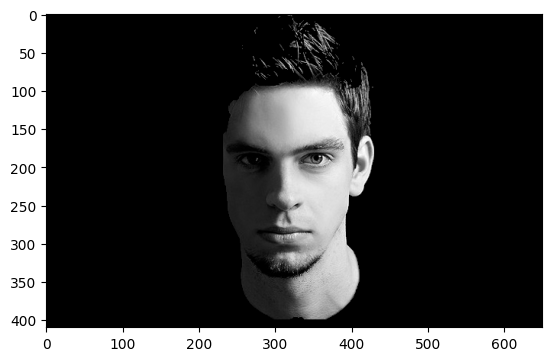

In [5]:
outputMask = np.where((mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD),
	0, 1)
# scale the mask from the range [0, 1] to [0, 255]
outputMask = (outputMask * 255).astype("uint8")
# apply a bitwise AND to the image using our mask generated by
# GrabCut to generate our final output image
output = cv2.bitwise_and(image, image, mask=outputMask)
plt.imshow( output)
plt.show()

## Program wykonujący segmentacje na pdostawie kamerki laptopa

Zgodnie z ustaleniami poczynionymi w trakcie konsultacji, opracowałem program który wykonuje segmentację metodą **GrabCut** na obrazie zarejestrowanym przez kamerkę komputera. 
Tak aby zasymulować działania funkcjonalności aplikacji Teams która umozliwia dodanie tla do obrazu wideo w trakice rozmowy.

Program dokonuje segmentacji i umieszcza wysegmentowany obiekt na tle plazy (stałe zdefiniowane tło).

Program mozna uruchomic za pomocą kolejnej komórki z kodem. Jako argument nalezy nazwe folderu w którym chcemy aby zapisały się wyniki segmentacji. Program sam utworzy dany folder.
Urochmienia komórki z taką zawartością:
```console
!python3 from_video.py <nazwa-folderu>

```
Sprawi, ze program utworzy folder o nazwie **\<nazwa-folderu\>** i zapisze w nim wyniki segmentacji wrac z oryginalnymi obrazami.


### Instrukcja korzystania z programu

 1. Program wymaga dostępu do kamery w komputerze. Przy jego uruchomieniu moze byc konieczne wyrazenie na to zgody.
 2. Otworzy sie okno z obrazem z kamery z laptopa. Zacznij od zaznaczenia prostokątu w obrębie którego będzie wykonywana segmentacja. W tym celu kliknij w miejscu gdzie chciałbyś aby był lewy górny róg prostokątu a następnie w miejscu gdzie chciałbyś aby był prawy dolny róg prostokątu.
  W dowolnym momencie mozesz zmienic prostokat klikajac jeszcze raz.
 3. Klikając **spację** zapiszmey obecny obraz z kamery oraz wynik segmentacyjny na tle plazy, oba obrazy zostaną zapisane w folderze wskazanym w trakcie uruchamiania programu.
 4. W dowolnym momencie mozemy zakonczyc dzialania programu klikając przycisk **escape**.



 Sam program korzysta dokładnie z tych samych funkcji jak te opisane wyzej, dodatkowo zawarta w nim jest logika zwiazana z obsługą kliknięć przycisków i myszki przez uzytkownika.

In [7]:
!python3 from_camera.py output_folder

2024-06-02 16:44:10.968 Python[63805:4467057] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
